In [171]:
%matplotlib inline
import talib as ta
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [172]:
class TALibVolatilityStudies:
    
    def ATR(self, high, low, close, period, feature_dict):
        feature_dict['ATR_'+str(period)]='Keep'
        averageTR = ta.ATR(
            high,
            low,
            close,
            #defualt is 14
            period)
        return averageTR, feature_dict
 
    def NATR(self, high, low, close, period, feature_dict):
        feature_dict['NormalizedATR_'+str(period)]='Keep'
        normalizedATR = ta.NATR(
            high,
            low,
            close,
            #defualt is 14
            period)
        return normalizedATR, feature_dict
    
    def ATR_Ratio(self, high, low, close, shortperiod, longperiod, feature_dict):
        feature_dict['ATRratio_S'+str(shortperiod)+"_L"+str(longperiod)]='Keep'
        shortATR =  ta.ATR(
            high,
            low,
            close,
            #defualt is 14
            shortperiod) 
        longATR =  ta.ATR(
            high,
            low,
            close,
            #defualt is 14
            longperiod)
        atr_Ratio = shortATR / longATR
        return atr_Ratio, feature_dict
    
    def Delta_ATR_Ratio(self, high, low, close, shortperiod, longperiod, delta, feature_dict):
        temp_dict={}
        feature_dict['DeltaATRratio_S'+str(shortperiod)+'_L'+str(longperiod)+'_D'+str(delta)]='Keep'
        current_ATR_Ratio, temp_dict = self.ATR_Ratio(high, low, close, shortperiod, longperiod, temp_dict)
        nrows = current_ATR_Ratio.shape[0]
        delta_ATR_Ratio = np.zeros(nrows)
        for i in range (delta,nrows):
            delta_ATR_Ratio[i] = current_ATR_Ratio[i] - current_ATR_Ratio[i-1] 
        return delta_ATR_Ratio, feature_dict
    
    def BBWidth(self, close, period, feature_dict):
        feature_dict['BollBandWidth_'+str(period)] = 'Keep'
        taLibOS = TALibOverlapStudies()
        upperBand, middleBand, lowerBand, feature_dict = taLibOS.BollBands(
            close, period, 2, feature_dict)
        bollBandWidth = ((upperBand - lowerBand) / middleBand ) * 100
        return bollBandWidth, feature_dict
    

In [173]:
import sys
sys.path.append('./lib')
sys.path.append('./utilities')
from plot_utils import *
from retrieve_data import *
from ta_overlap_studies import *
dataLoadStartDate = "2014-04-01"
dataLoadEndDate = "2018-04-01"
issue = "ABBV"
feature_dict = {}

taLibVoltltySt = TALibVolatilityStudies()
    
dSet = DataRetrieve()
dataSet = dSet.read_issue_data(issue)
    
dataSet = dSet.set_date_range(dataSet, dataLoadStartDate,dataLoadEndDate)

Successfully retrieved data series for ABBV


In [174]:
dataSet['pct_change'] = dataSet.Pri.pct_change()
#dataSet['log_return'] = np.log(1 + dataSet.pct_change)
dataSet['log_return'] = np.log(dataSet.Pri).diff()

In [175]:
print(dataSet.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2014-04-01 to 2018-03-30
Freq: C
Data columns (total 9 columns):
Symbol        1004 non-null object
Close         1004 non-null float64
High          1004 non-null float64
Low           1004 non-null float64
Open          1004 non-null float64
Volume        1004 non-null int64
Pri           1004 non-null float64
pct_change    1003 non-null float64
log_return    1003 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 78.4+ KB
None


In [195]:
taLibOS = TALibOverlapStudies()
temp_dict = {}

short_period = 10
short_period_mult = 10
long_period = short_period * short_period_mult

#pd.rolling_mean(df['Close'], 100)

#ShortMA = taLibOS.SimpleMA(dataSet.log_return.values, short_period, temp_dict)
#LongMA = taLibOS.SimpleMA(dataSet.log_return.values, long_period, temp_dict)

ATR_temp, feature_dict = taLibVoltltySt.ATR(
    np.log(dataSet.High).values, 
    np.log(dataSet.Low).values, 
    np.log(dataSet.Pri).values, 
    int(short_period * short_period_mult),
    feature_dict)

dataSet['tempAbsPriceChgOsc'] = (pd.rolling_mean(dataSet['log_return'], long_period) -
                                     pd.rolling_mean(dataSet['log_return'], short_period)) / ATR_temp




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


In [196]:
dataSet['tempAbsPriceChgOsc'].fillna(0, inplace=True)
scaler = MinMaxScaler(feature_range=(-50,50))


In [197]:
dataSet["AbsPriceChgOsc"] = scaler.fit_transform(dataSet[['tempAbsPriceChgOsc']])

In [198]:
dataSet['ATR_20'], feature_dict = taLibVoltltySt.ATR(
    dataSet.High.values, 
    dataSet.Low.values, 
    dataSet.Pri.values, 
    20, 
    feature_dict)

dataSet['NormATR_14'], feature_dict = taLibVoltltySt.NATR(
    dataSet.High.values, 
    dataSet.Low.values, 
    dataSet.Pri.values, 
    14, 
    feature_dict)

dataSet['ATRRatio_S10_L20'], feature_dict = taLibVoltltySt.ATR_Ratio(
    dataSet.High.values, 
    dataSet.Low.values, 
    dataSet.Pri.values, 
    10,
    20,
    feature_dict)

dataSet['DeltaATRRatio_S10_L20_D5'], feature_dict = taLibVoltltySt.Delta_ATR_Ratio(
    dataSet.High.values, 
    dataSet.Low.values, 
    dataSet.Pri.values, 
    10,
    20,
    5,
    feature_dict)

dataSet['BBWidth_20'], feature_dict = taLibVoltltySt.BBWidth(
    dataSet.Pri.values, 
    20, 
    feature_dict)

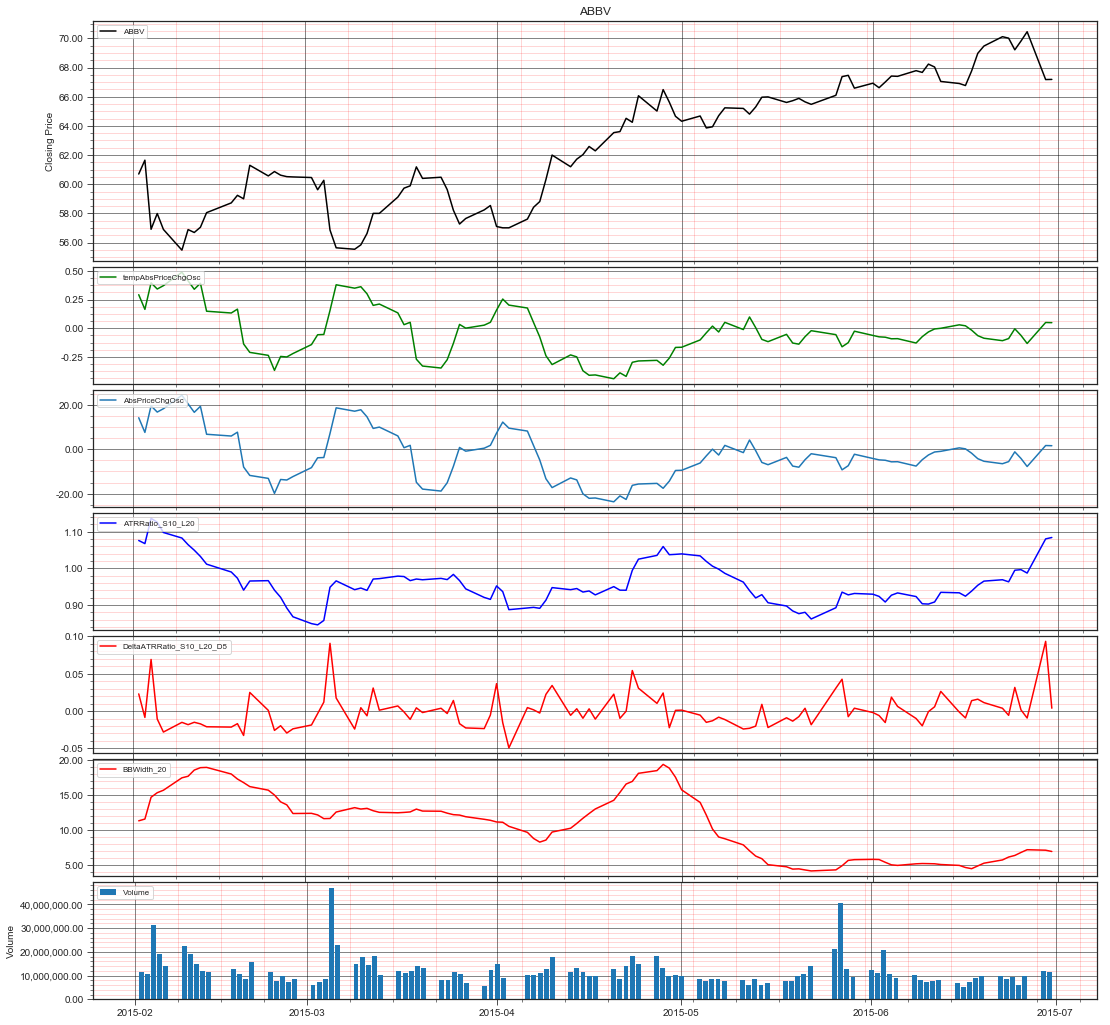

In [199]:
startDate = "2015-02-01"
endDate = "2015-06-30"
rsiDataSet = dataSet.ix[startDate:endDate]
plt.figure(figsize=(18,18))
horizplots = 8
top = plt.subplot2grid((horizplots,4), (0, 0), rowspan=2, colspan=4)
middle = plt.subplot2grid((horizplots,4), (2, 0), rowspan=1, colspan=4)
middle2 = plt.subplot2grid((horizplots,4), (3, 0), rowspan=1, colspan=4)
middle3 = plt.subplot2grid((horizplots,4), (4, 0), rowspan=1, colspan=4)
middle4 = plt.subplot2grid((horizplots,4), (5, 0), rowspan=1, colspan=4)
middle5 = plt.subplot2grid((horizplots,4), (6, 0), rowspan=1, colspan=4)
bottom = plt.subplot2grid((horizplots,4), (7, 0), rowspan=1, colspan=4)

top.plot(rsiDataSet.index, rsiDataSet['Pri'], 'k-', markersize=3,label=issue)
middle.plot(rsiDataSet.index, rsiDataSet['tempAbsPriceChgOsc'], 'g-')
middle2.plot(rsiDataSet.index, rsiDataSet['AbsPriceChgOsc'], '-')
middle3.plot(rsiDataSet.index, rsiDataSet['ATRRatio_S10_L20'], 'b-')
middle4.plot(rsiDataSet.index, rsiDataSet['DeltaATRRatio_S10_L20_D5'], 'r-')
middle5.plot(rsiDataSet.index, rsiDataSet['BBWidth_20'], 'r-')
bottom.bar(rsiDataSet.index, rsiDataSet['Volume'], label='Volume')

plt.subplots_adjust(hspace=0.05)
# set the labels
top.axes.get_xaxis().set_visible(True)
top.set_title(str(issue))
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')

#top.axhline(y=30, color='red', linestyle='-', alpha=0.4)
#top.axhline(y=70, color='blue', linestyle='-', alpha=0.4)
#middle.axhline(y=0, color='black', linestyle='-', alpha=0.4)

for ax in top, middle, middle2, middle3, middle4, middle5, bottom:
                ax.label_outer()
                ax.legend(loc='upper left', frameon=True, fontsize=8)
                ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.02f}'))
                ax.grid(True, which='both')
                ax.xaxis_date()
                ax.autoscale_view()
                ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                ax.minorticks_on()